# Normal Distribution

> Each feature distributes like a normal distribution

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import norm
from fastai.vision.all import *

from similarity_learning.all import *

from Few_Shot_Feature_Space.utils import *

In [ ]:
def per_component_hist(xs, axs):
    pca = PCA()
    pca.fit(xs.cpu())
        
    comp_idxs = [i*pca.n_components_//(len(axs)-1) for i in range(len(axs)-1)] + [pca.n_components_-1]
    for comp_idx, ax in zip(comp_idxs, axs):
        dir = Tensor(pca.components_[comp_idx]).cuda()
        projected = (xs @ dir).cpu()
        plot_hist(projected, ax=ax)
        ax.set_title(f'Component #{comp_idx+1} out of {pca.n_components_}')

def class_mean_per_components(centroids, n_plots):
    fig, axs = plt.subplots(1, n_plots, figsize=(n_plots*5, 5))
    fig.suptitle('Class Mean Distributions Across PCA Components')
    per_component_hist(centroids, axs)

def off_mean_per_classes_and_components(class_ftrs, n_plots):
    fig, axss = plt.subplots(4, n_plots, figsize=(n_plots*5, 20))
    fig.suptitle('Off-Mean Distributions Across Classes and PCA Components')
    cluster_candidates = [f for f in class_ftrs.values() if f.size(0) > 100]
    for ftrs, axs in zip(random.sample(cluster_candidates, len(axss)), axss):
        per_component_hist(ftrs.off_centroid_features, axs)

## Class Means

In [ ]:
def plot(dl, fe, n_plots=5):
    class_ftrs = ClassFeatures.compute(dl, fe)
    centroids = torch.stack([f.centroid for f in class_ftrs.values()])
    global_mean = centroids.mean(0)

    class_mean_per_components(centroids - global_mean, n_plots)

    off_mean_per_classes_and_components(class_ftrs, n_plots)

In [ ]:
vggface2_fe, casia_webface_fe = fr_feature_extractors()
lfw_dl, pfr_dl = fr_dataloaders()

## VGGFace2

### LFW

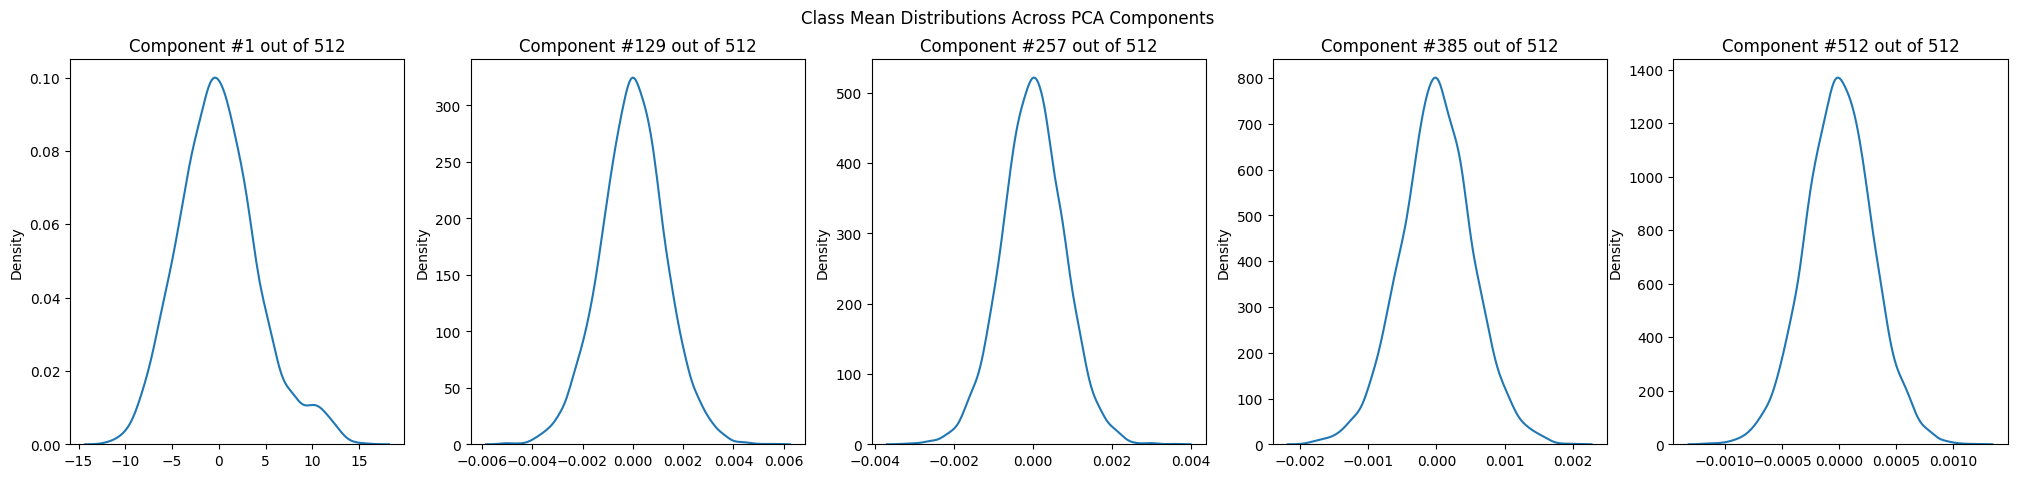

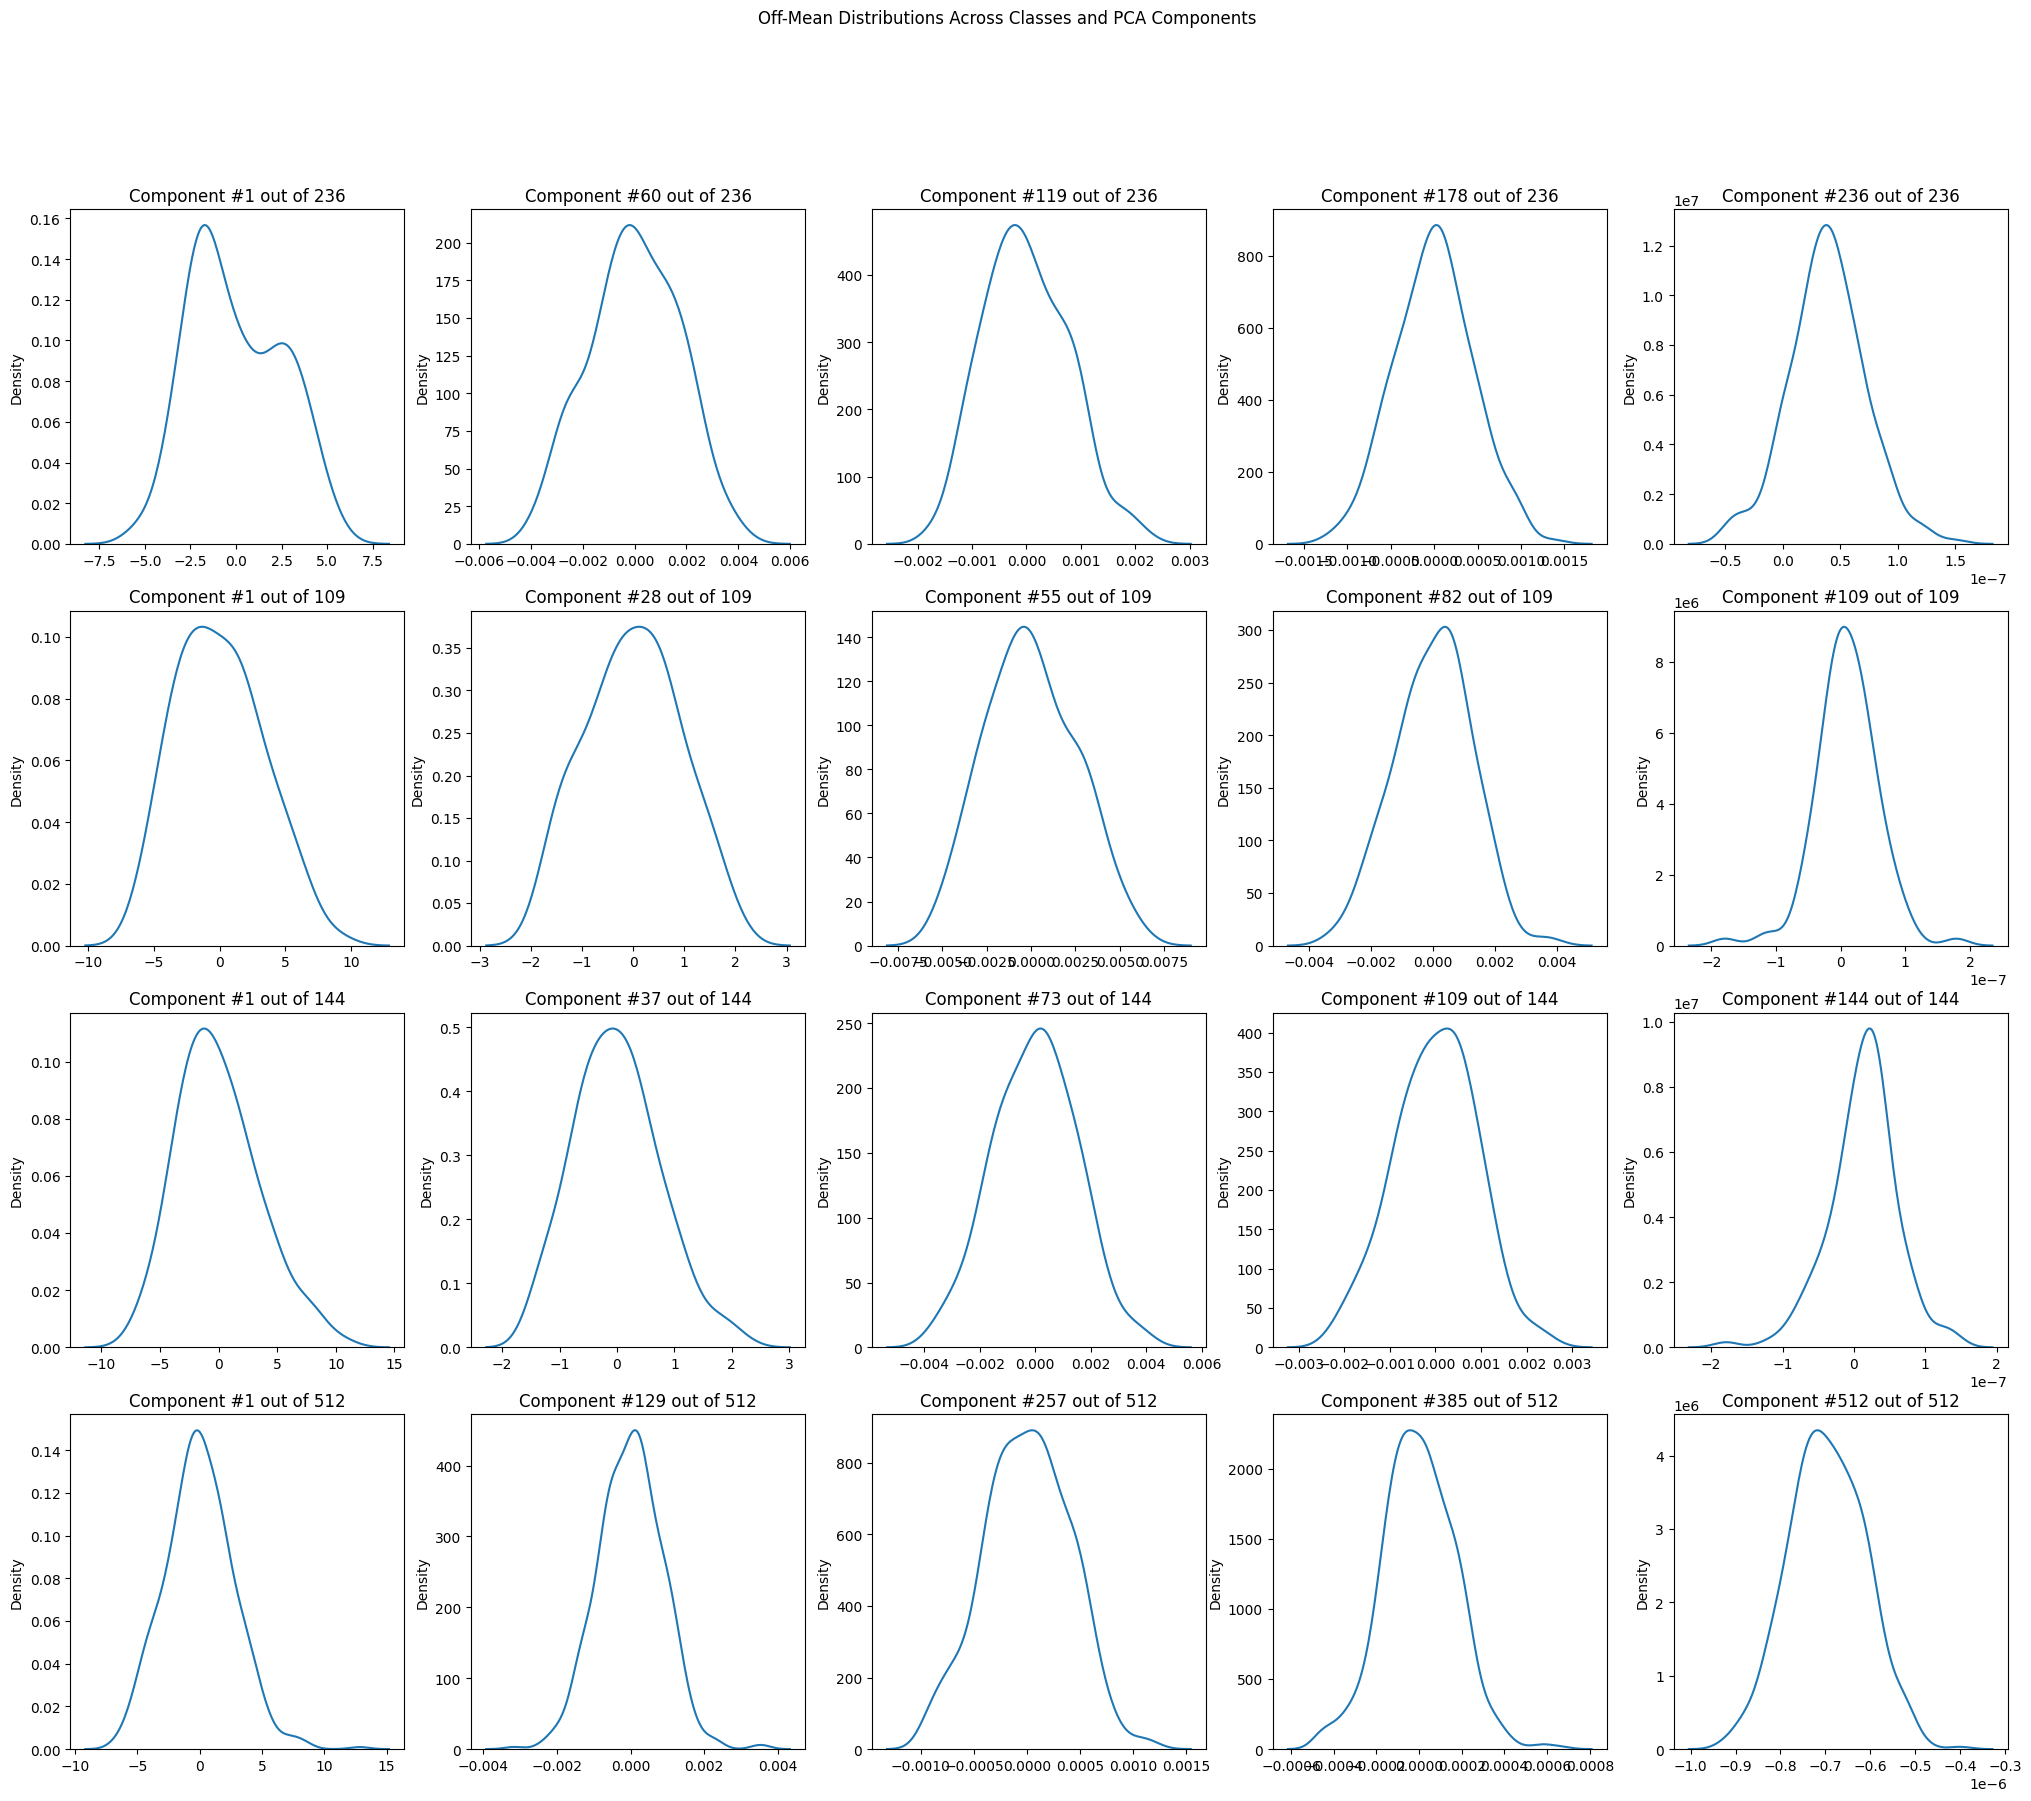

In [ ]:
plot(lfw_dl, vggface2_fe)

### PFR

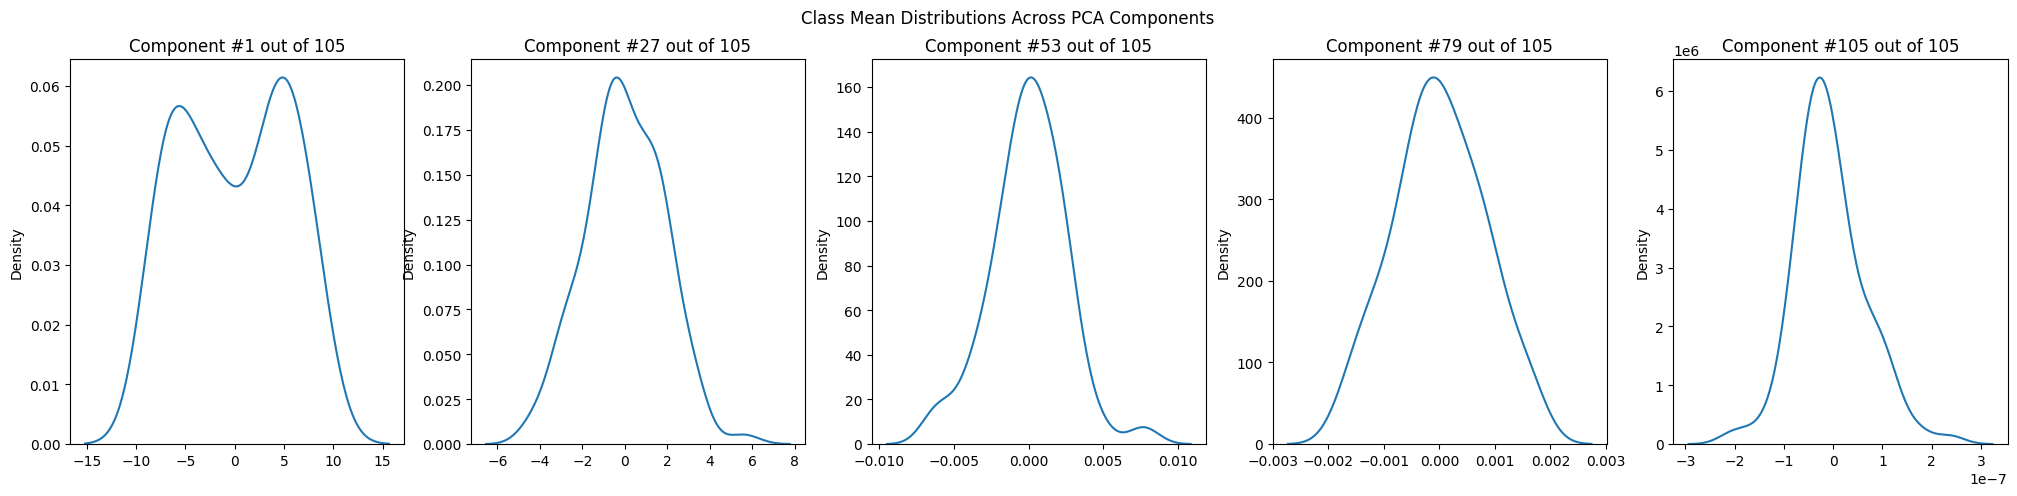

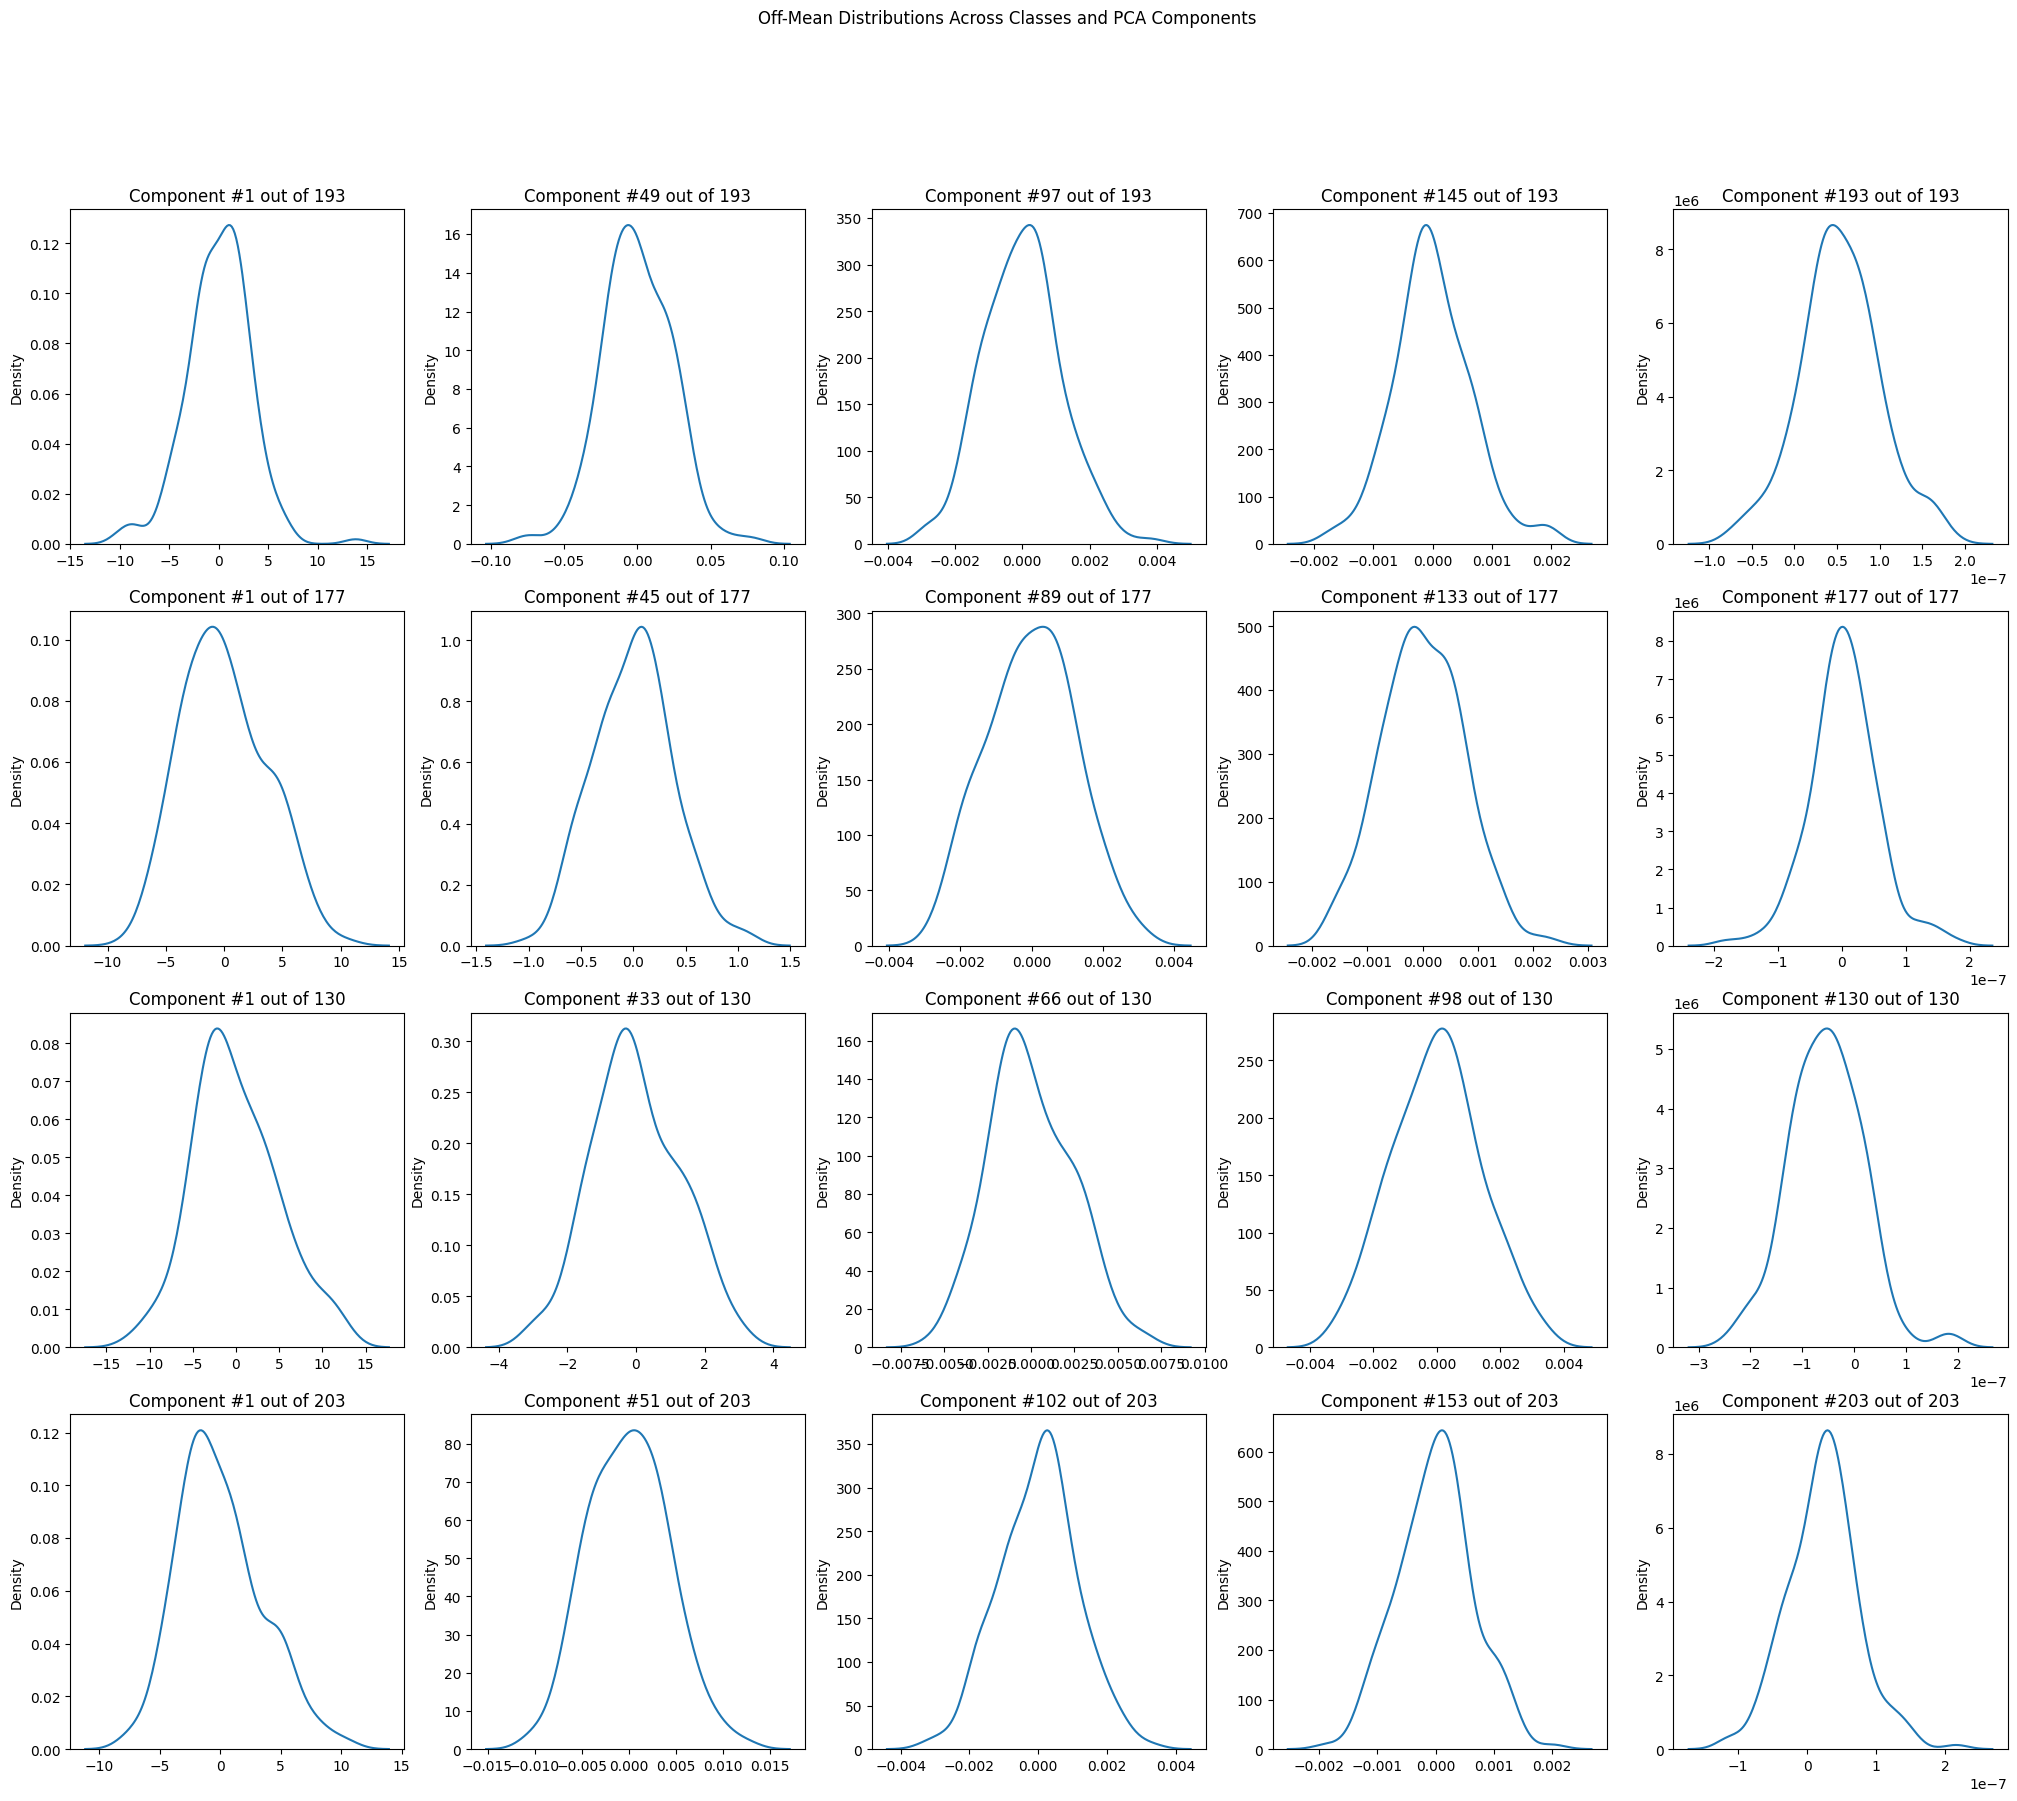

In [ ]:
plot(pfr_dl, vggface2_fe)

## CASIA-WebFace

### LFW

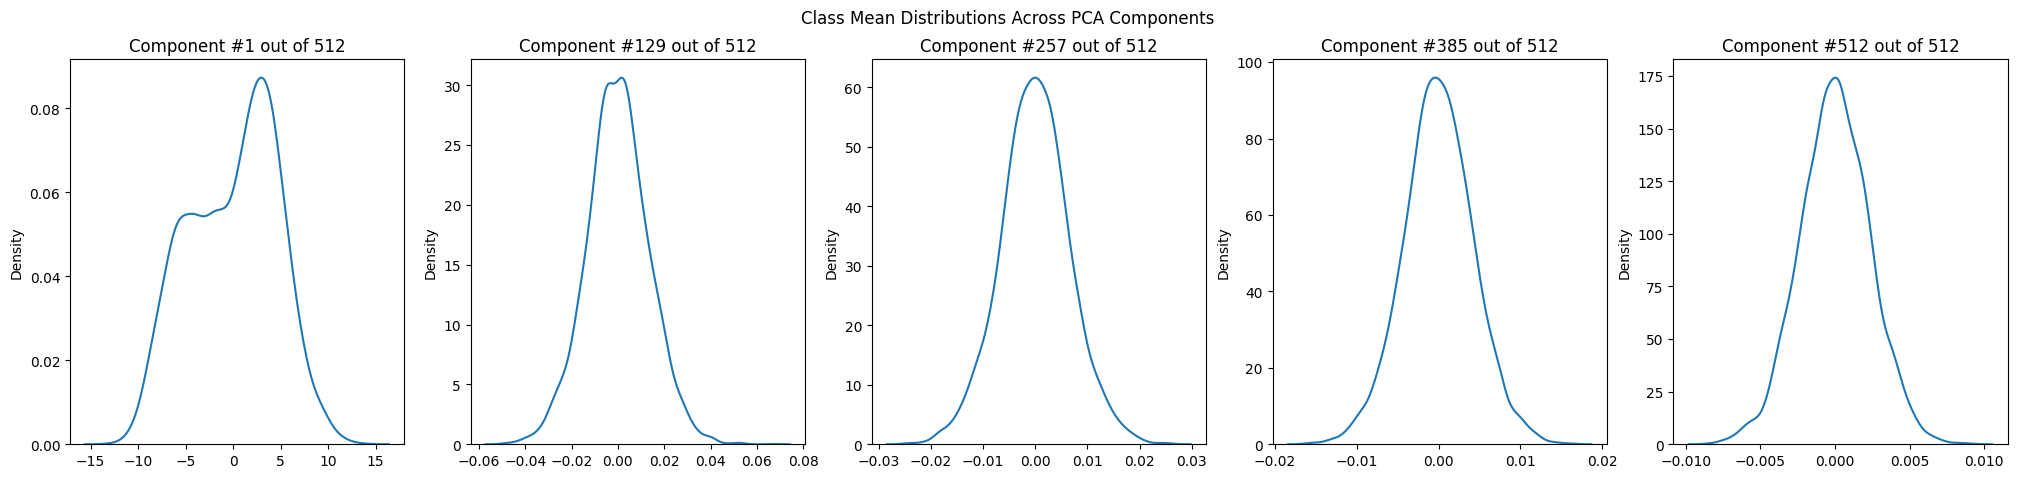

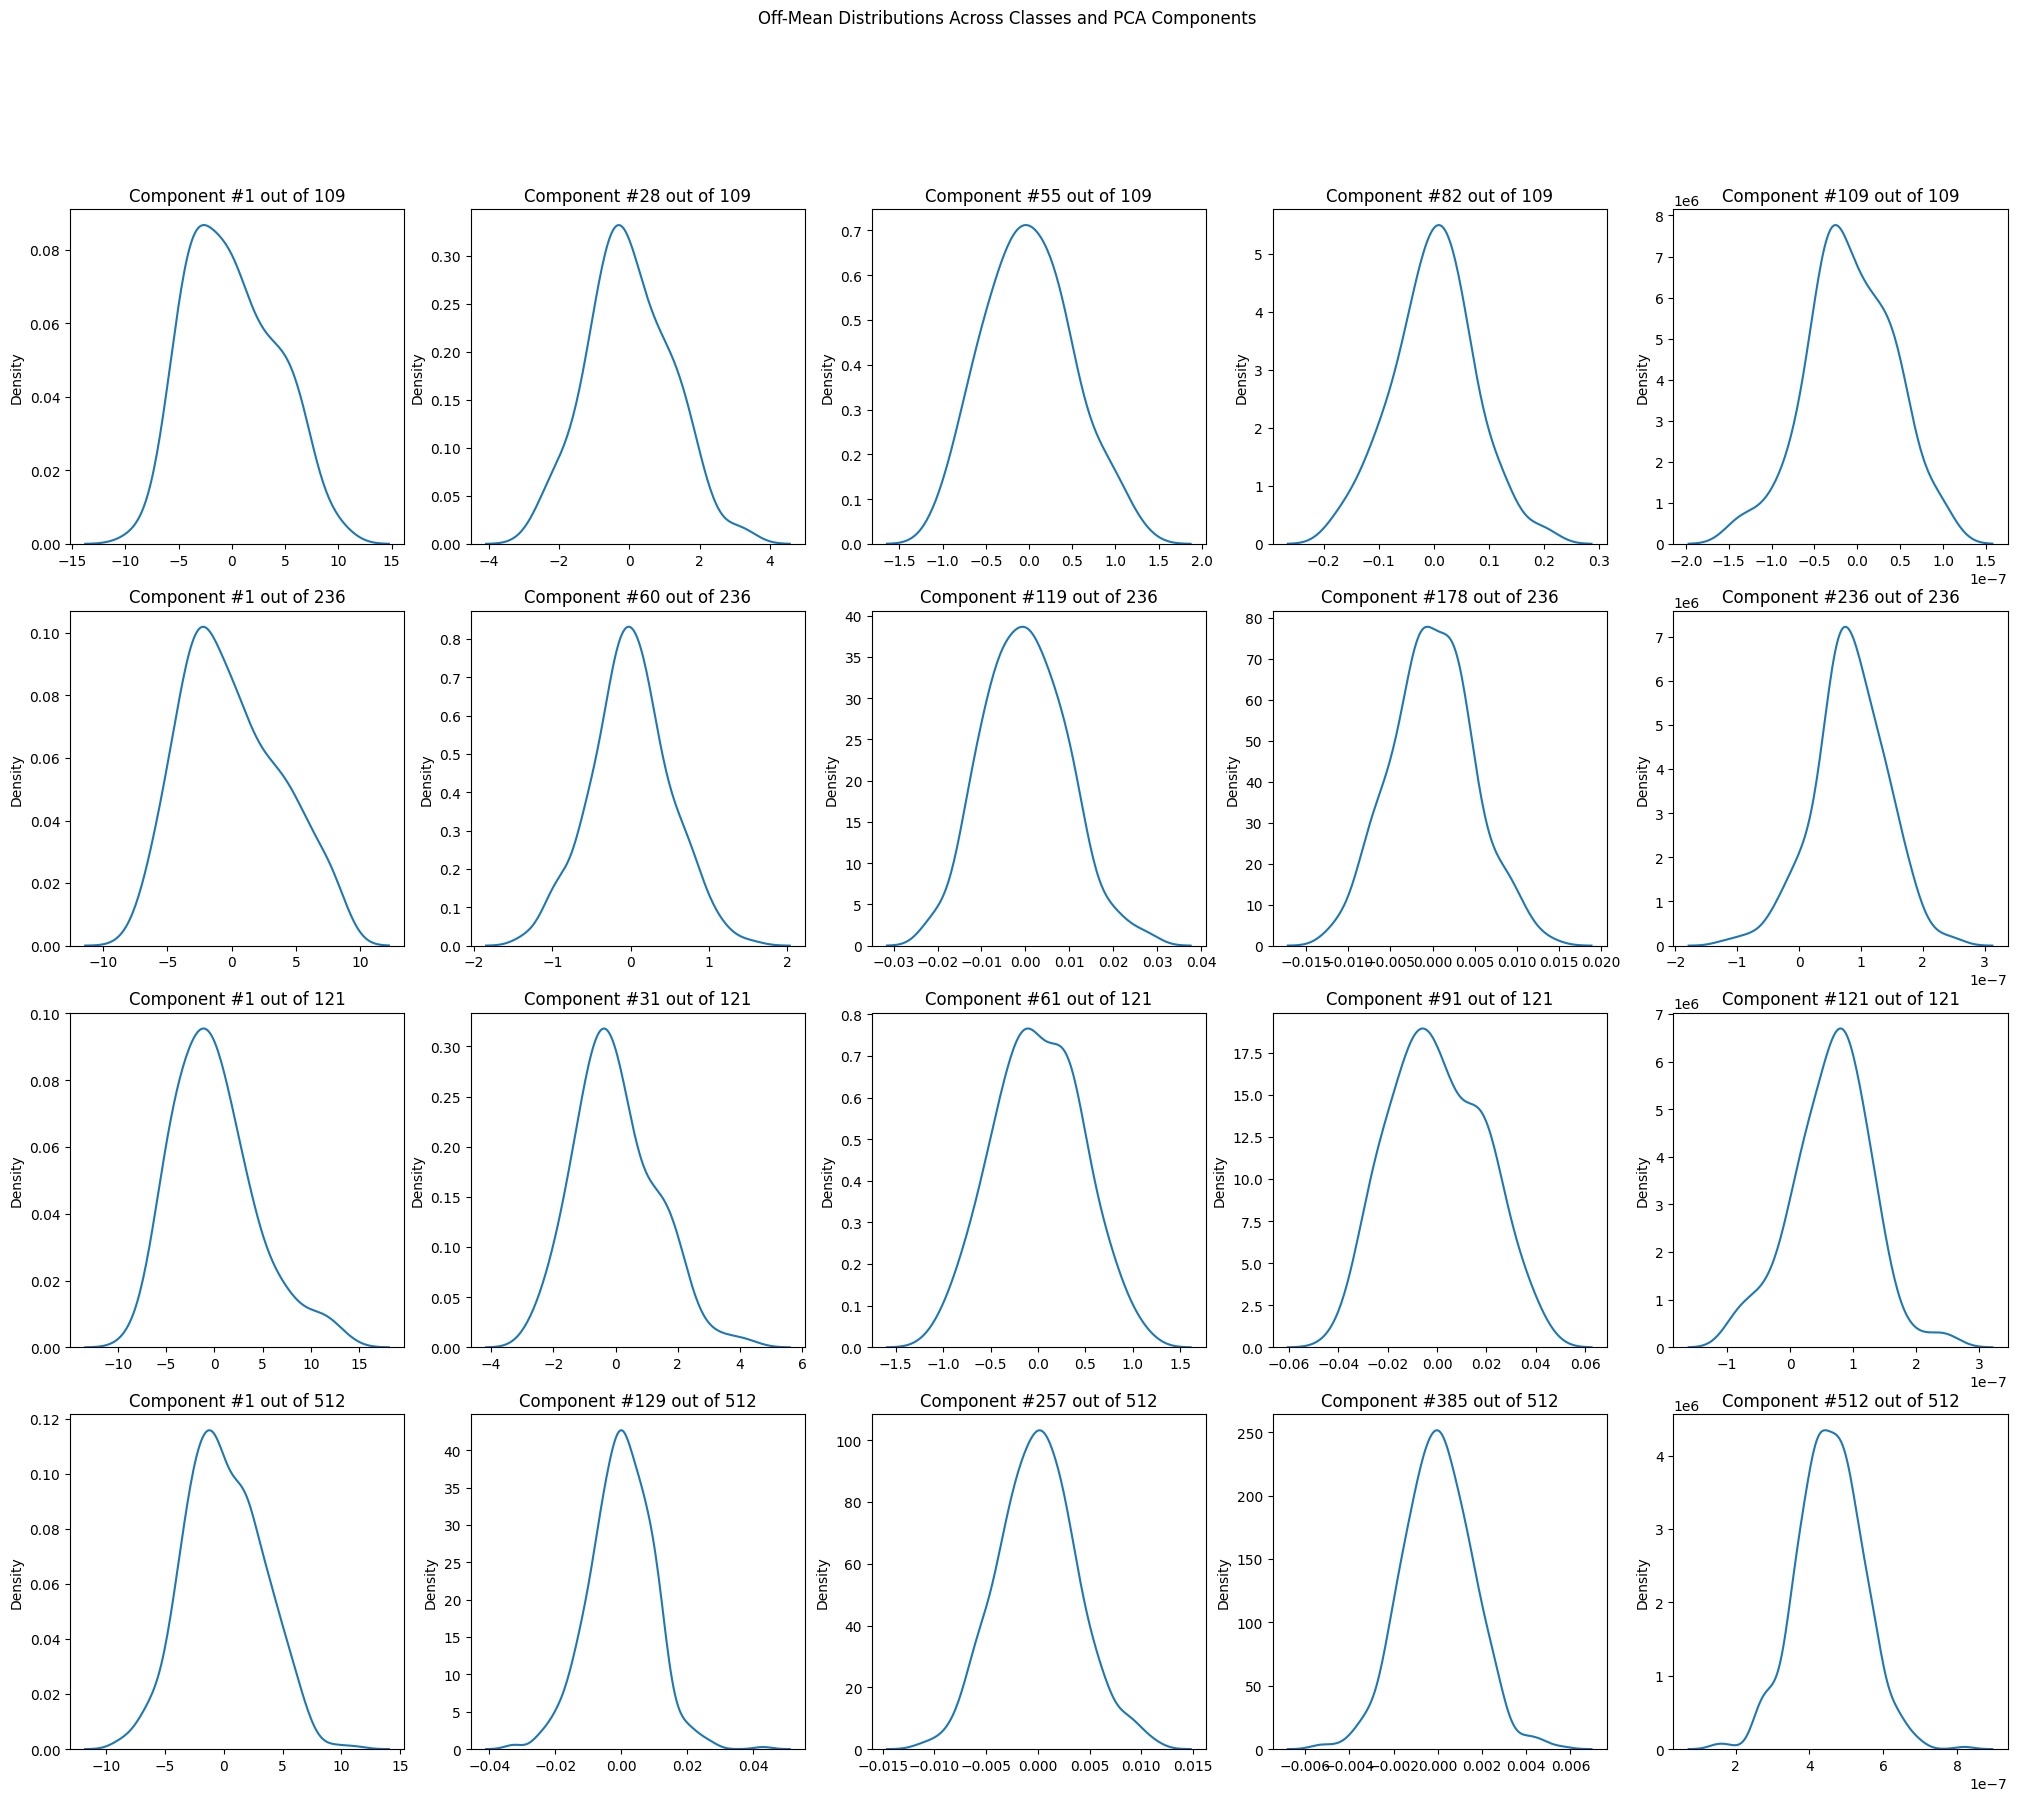

In [ ]:
plot(lfw_dl, casia_webface_fe)

### PFR

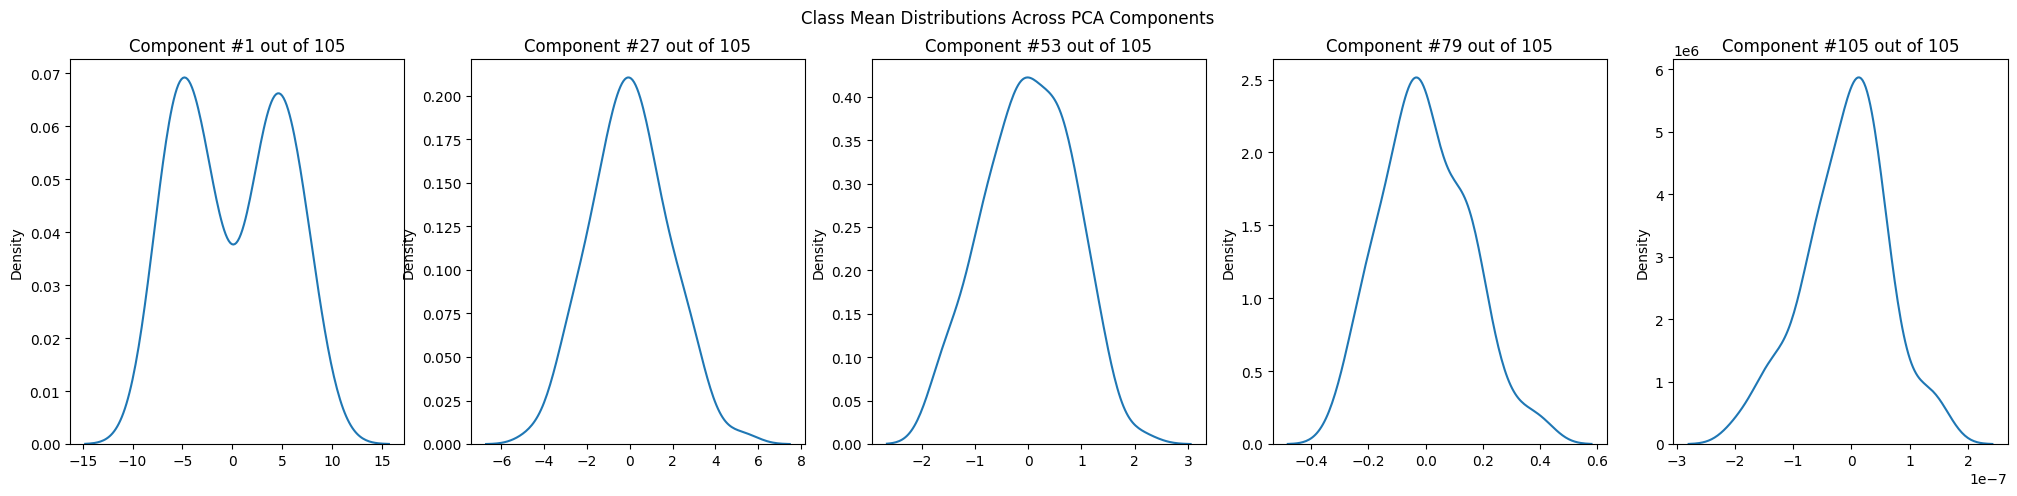

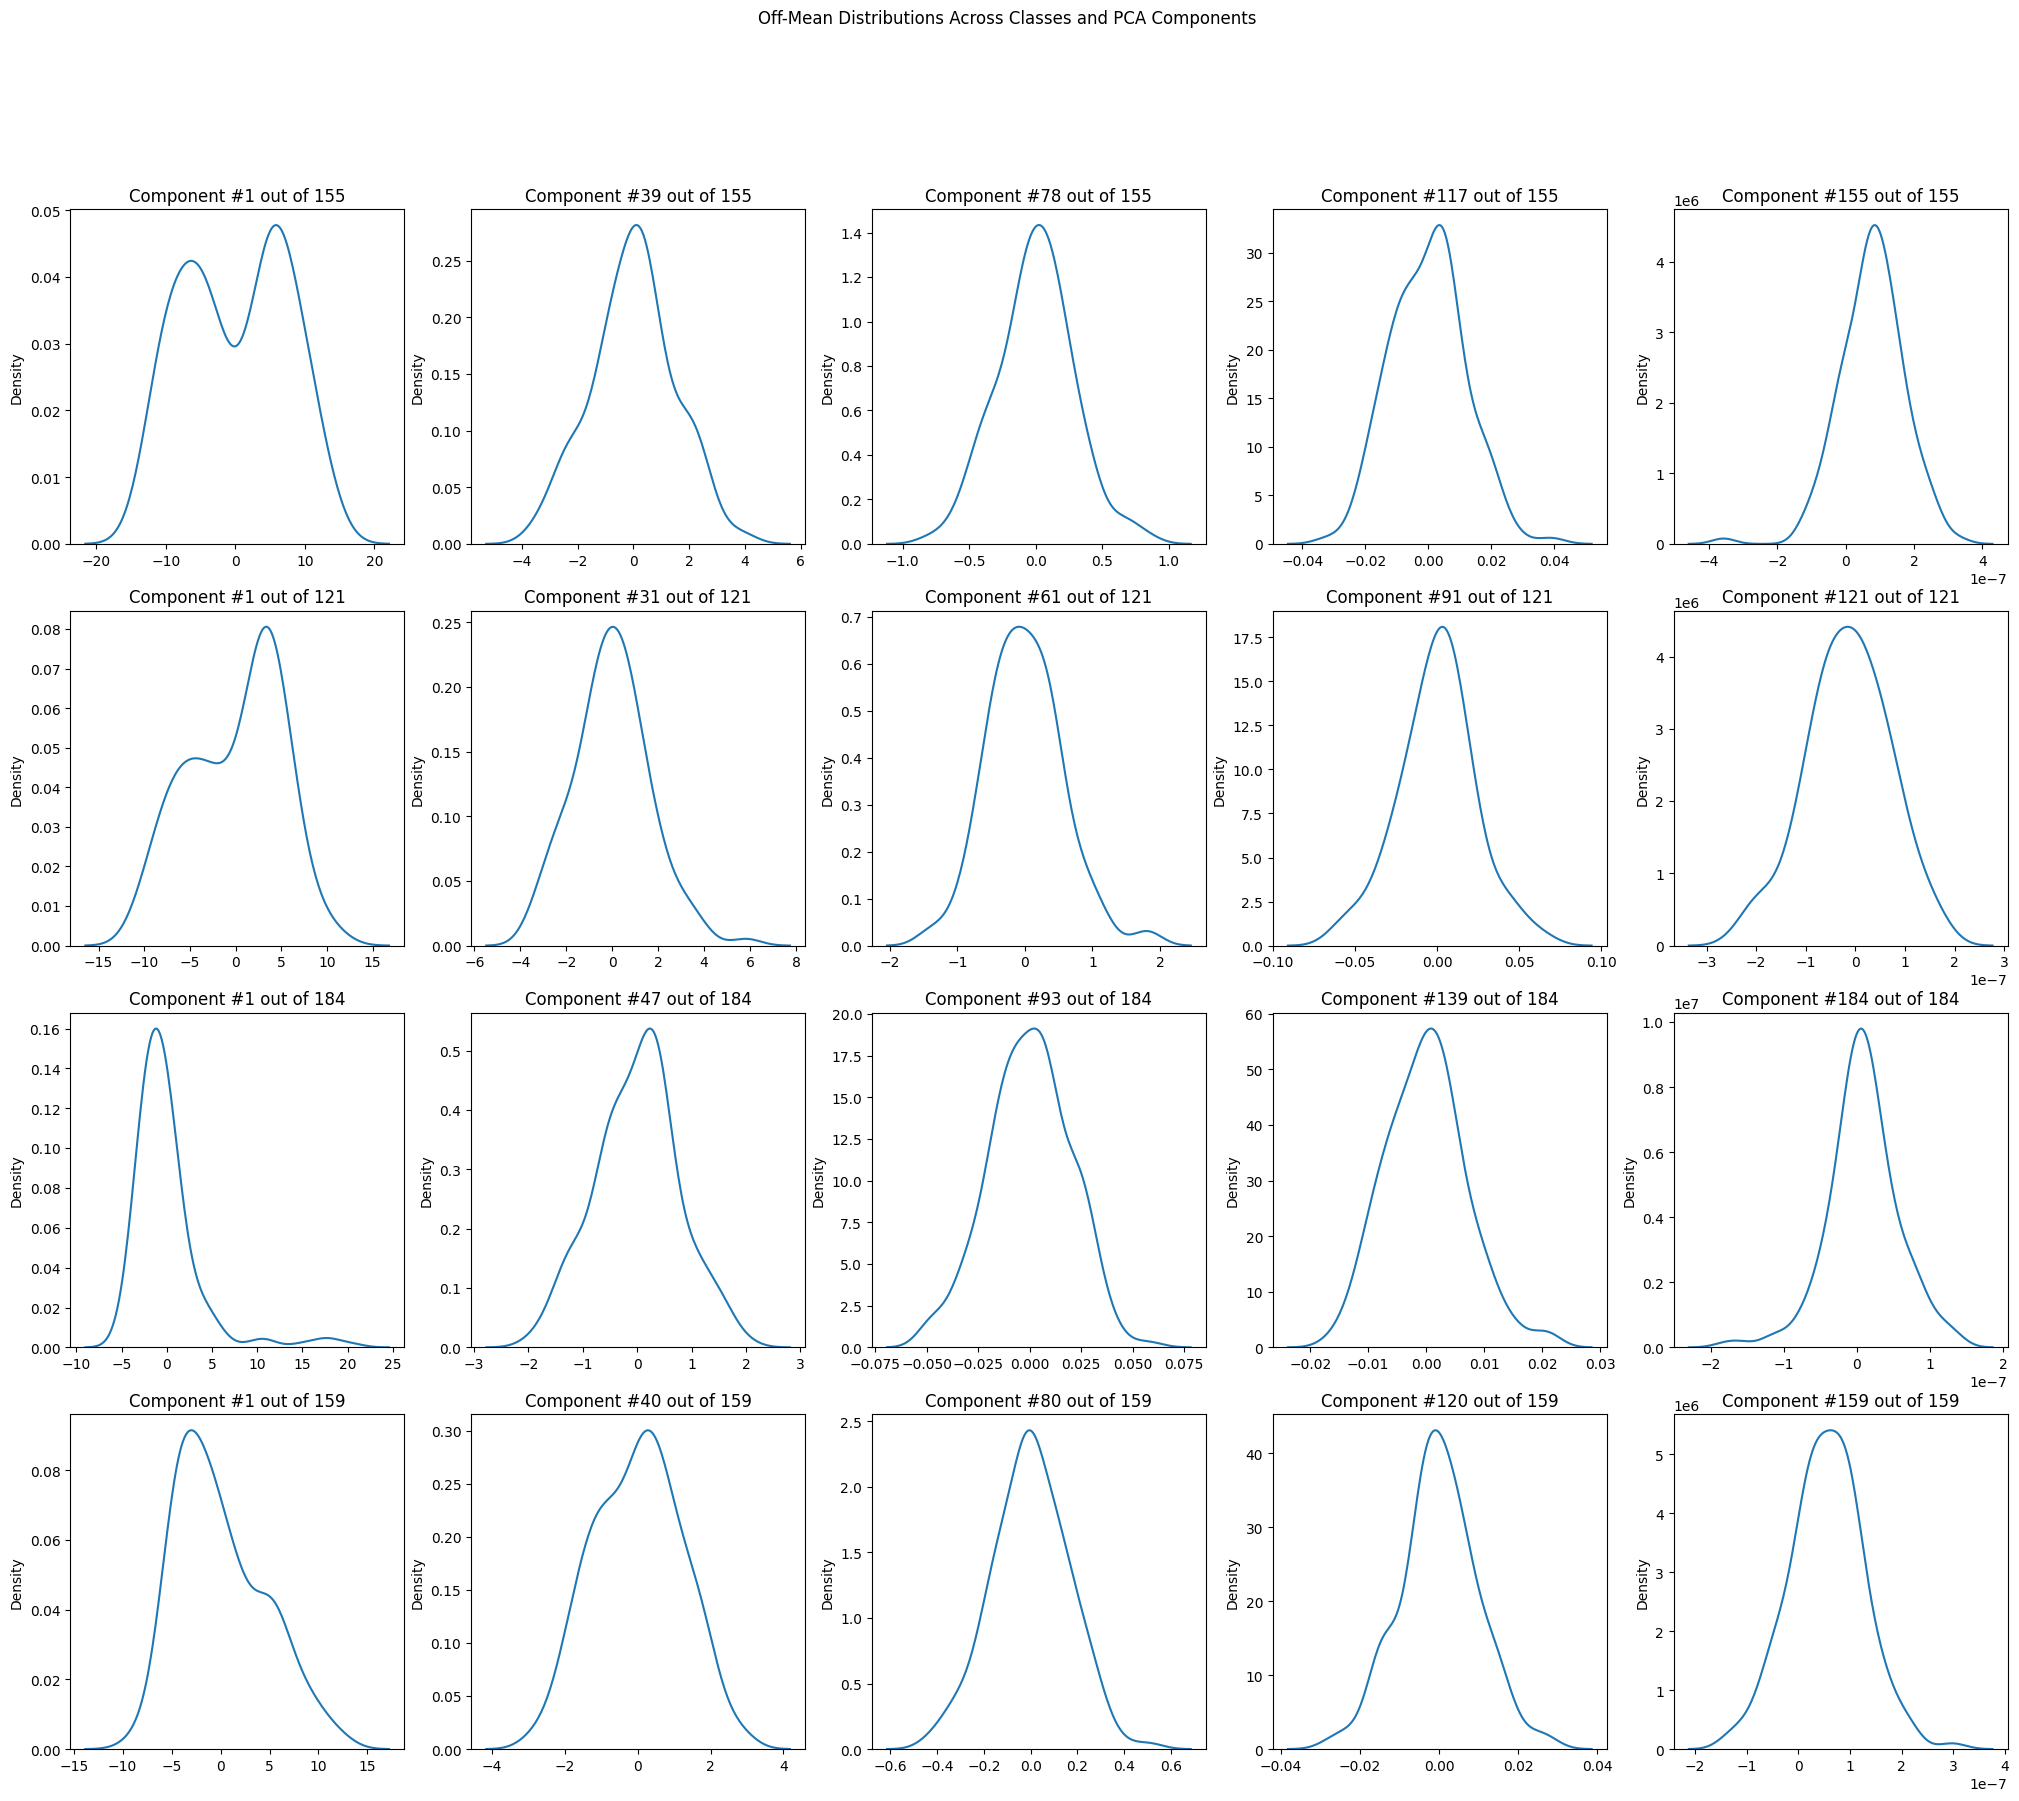

In [ ]:
plot(pfr_dl, casia_webface_fe)